# Dataset

In [1]:
from torch.utils.data import Dataset
from PIL import Image
import torch
#import config
import torchvision.transforms as transforms
import numpy as np
from sklearn import preprocessing

def readTxt(file_path):
    img_list = []
    with open(file_path, 'r') as file_to_read:
        while True:
            lines = file_to_read.readline()
            if not lines:
                break
            item = lines.strip().split()
            img_list.append(item)
    file_to_read.close()
    return img_list

class RoadSequenceDatasetList(Dataset):

    def __init__(self, file_path, transforms):

        self.img_list = readTxt(file_path)
        self.dataset_size = len(self.img_list)
        self.transforms = transforms
    def __len__(self):
        return self.dataset_size

    def __getitem__(self, idx):
        img_path_list = self.img_list[idx]
        data = []
        for i in range(5):
            data.append(torch.unsqueeze(self.transforms(Image.open(img_path_list[i])), dim=0))
        data = torch.cat(data, 0)
        label = Image.open(img_path_list[5])
        label = torch.squeeze(self.transforms(label))
        sample = {'data': data, 'label': label}
        return sample

# Dataloader

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_path = 'D:/Kuliah/SEMESTER 8/Robust-Lane-Detection-master/Robust-Lane-Detection-master/LaneDetectionCode/data/train_index.txt'
val_path = 'D:/Kuliah/SEMESTER 8/Robust-Lane-Detection-master/Robust-Lane-Detection-master/LaneDetectionCode/data/DatasetList.txt'
transform = transforms.Compose([transforms.ToTensor()])
batch_size = 4;
from torch.utils.data import DataLoader
train_set = RoadSequenceDatasetList(file_path=train_path,transforms=transform)
trainloader = DataLoader(train_set,batch_size=batch_size,shuffle=True)
val_set = RoadSequenceDatasetList(file_path=val_path,transforms=transform)
val_loader = DataLoader(val_set,batch_size=batch_size,shuffle=True)

In [16]:
device

device(type='cuda')

# Model

## Utils

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import numpy as np
from torch.autograd import Variable

class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x


class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            double_conv(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x


class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()

        #  would be a nice idea if the upsampling could be learned too,
        #  but my machine do not have enough memory to handle all those weights
        if bilinear:
            self.up = nn.UpsamplingBilinear2d(scale_factor=2)
        else:
            self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffX = x1.size()[2] - x2.size()[2]
        diffY = x1.size()[3] - x2.size()[3]
        x2 = F.pad(x2, (diffX // 2, int(diffX / 2),
                        diffY // 2, int(diffY / 2)))
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x


class ConvLSTMCell(nn.Module):

    def __init__(self, input_size, input_dim, hidden_dim, kernel_size, bias):
        """
        Initialize ConvLSTM cell.

        Parameters
        ----------
        input_size: (int, int)
            Height and width of input tensor as (height, width).
        input_dim: int
            Number of channels of input tensor.
        hidden_dim: int
            Number of channels of hidden state.
        kernel_size: (int, int)
            Size of the convolutional kernel.
        bias: bool
            Whether or not to add the bias.
        """

        super(ConvLSTMCell, self).__init__()

        self.height, self.width = input_size
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.kernel_size = kernel_size
        self.padding = kernel_size[0] // 2, kernel_size[1] // 2
        self.bias = bias

        self.conv = nn.Conv2d(in_channels=self.input_dim + self.hidden_dim,
                              out_channels=4 * self.hidden_dim,
                              kernel_size=self.kernel_size,
                              padding=self.padding,
                              bias=self.bias)

    def forward(self, input_tensor, cur_state):
        h_cur, c_cur = cur_state

        combined = torch.cat([input_tensor, h_cur], dim=1)  # concatenate along channel axis

        combined_conv = self.conv(combined)

        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)

        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)

        return h_next, c_next

    def init_hidden(self, batch_size):
        return (torch.zeros(batch_size, self.hidden_dim, self.height, self.width).cuda(),
                torch.zeros(batch_size, self.hidden_dim, self.height, self.width).cuda())


class ConvLSTM(nn.Module):

    def __init__(self, input_size, input_dim, hidden_dim, kernel_size, num_layers,
                 batch_first=False, bias=True, return_all_layers=False):
        super(ConvLSTM, self).__init__()

        self._check_kernel_size_consistency(kernel_size)

        # Make sure that both `kernel_size` and `hidden_dim` are lists having len == num_layers
        kernel_size = self._extend_for_multilayer(kernel_size, num_layers)
        hidden_dim = self._extend_for_multilayer(hidden_dim, num_layers)
        if not len(kernel_size) == len(hidden_dim) == num_layers:
            raise ValueError('Inconsistent list length.')

        self.height, self.width = input_size

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.bias = bias
        self.return_all_layers = return_all_layers

        cell_list = []
        for i in range(0, self.num_layers):
            cur_input_dim = self.input_dim if i == 0 else self.hidden_dim[i - 1]

            cell_list.append(ConvLSTMCell(input_size=(self.height, self.width),
                                          input_dim=cur_input_dim,
                                          hidden_dim=self.hidden_dim[i],
                                          kernel_size=self.kernel_size[i],
                                          bias=self.bias))

        self.cell_list = nn.ModuleList(cell_list)

    def forward(self, input_tensor, hidden_state=None):
        """

        Parameters
        ----------
        input_tensor: todo
            5-D Tensor either of shape (t, b, c, h, w) or (b, t, c, h, w)
        hidden_state: todo
            None. todo implement stateful

        Returns
        -------
        last_state_list, layer_output
        """
        if not self.batch_first:
            # (t, b, c, h, w) -> (b, t, c, h, w)
            input_tensor=input_tensor.permute(1, 0, 2, 3, 4)

        # Implement stateful ConvLSTM
        if hidden_state is not None:
            raise NotImplementedError()
        else:
            hidden_state = self._init_hidden(batch_size=input_tensor.size(0))

        layer_output_list = []
        last_state_list = []

        seq_len = input_tensor.size(1)
        cur_layer_input = input_tensor

        for layer_idx in range(self.num_layers):

            h, c = hidden_state[layer_idx]
            output_inner = []
            for t in range(seq_len):
                h, c = self.cell_list[layer_idx](input_tensor=cur_layer_input[:, t, :, :, :],
                                                 cur_state=[h, c])


                output_inner.append(h)

            layer_output = torch.stack(output_inner, dim=1)
            cur_layer_input = layer_output

            layer_output = layer_output.permute(1, 0, 2, 3, 4)

            layer_output_list.append(layer_output)
            last_state_list.append([h, c])

        if not self.return_all_layers:
            layer_output_list = layer_output_list[-1:]
            last_state_list = last_state_list[-1:]

        return layer_output_list, last_state_list

    def _init_hidden(self, batch_size):
        init_states = []
        for i in range(self.num_layers):
            init_states.append(self.cell_list[i].init_hidden(batch_size))
        return init_states

    @staticmethod
    def _check_kernel_size_consistency(kernel_size):
        if not (isinstance(kernel_size, tuple) or
                (isinstance(kernel_size, list) and all([isinstance(elem, tuple) for elem in kernel_size]))):
            raise ValueError('`kernel_size` must be tuple or list of tuples')

    @staticmethod
    def _extend_for_multilayer(param, num_layers):
        if not isinstance(param, list):
            param = [param] * num_layers
        return param

## UNet-ConvLSTM

In [4]:
class UNet_ConvLSTM(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet_ConvLSTM, self).__init__()
        self.inc = inconv(n_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.up1 = up(1024, 256)
        self.up2 = up(512, 128)
        self.up3 = up(256, 64)
        self.up4 = up(128, 64)
        self.outc = outconv(64, n_classes)
        self.convlstm = ConvLSTM(input_size=(8,16),
                                 input_dim=512,
                                 hidden_dim=[512, 512],
                                 kernel_size=(3,3),
                                 num_layers=2,
                                 batch_first=False,
                                 bias=True,
                                 return_all_layers=False)

    def forward(self, x):
        x = torch.unbind(x, dim=1)
        data = []
        for item in x:
            x1 = self.inc(item)
            x2 = self.down1(x1)
            x3 = self.down2(x2)
            x4 = self.down3(x3)
            x5 = self.down4(x4)
            data.append(x5.unsqueeze(0))
        data = torch.cat(data, dim=0)
        lstm, _ = self.convlstm(data)
        test = lstm[0][ -1,:, :, :, :]
        x = self.up1(test, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return x, test

# Training Preparation

In [6]:
from torch import optim
import torch
#from jcopdl.callback import Callback, set_config
from _callback import CallbackSemSeg
from _config import set_config
learning_rate = 0.0005

In [7]:
config = set_config({
    'batch_size':batch_size,
    'learning_rate':learning_rate
})

In [8]:
path = 'D:/Kuliah/DeepLearning/Code/SemanticSegmentation/4_SemanticSegmentationTry/Tugas Akhir/3_TA_UNetConvLSTM/Epoch51/weights_best.pth'
model = UNet_ConvLSTM(3,2).to(device)
model.load_state_dict(torch.load(path))
criterion = nn.CrossEntropyLoss(weight=torch.Tensor([0.02, 2.02]).to(device))
optimizer = optim.Adam(model.parameters(),lr=learning_rate)
callback = CallbackSemSeg(model,config,outdir='Tugas Akhir/3_TA_UNetConvLSTM/Epoch51',plot_every=3,save_every=1,early_stop_patience=5)

In [6]:
path = 'D:/Kuliah/DeepLearning/Code/SemanticSegmentation/4_SemanticSegmentationTry/Tugas Akhir/3_TA_UNetConvLSTM/Epoch51/weights_best.pth'
model = UNet_ConvLSTM(3,2).to(device)
model.load_state_dict(torch.load(path))
criterion = nn.CrossEntropyLoss(weight=torch.Tensor([0.02, 2.02]).to(device))

# Evaluation Metrics

In [7]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image


class SegmentationMetrics(object):
    r"""Calculate common metrics in semantic segmentation to evalueate model preformance.
    Supported metrics: Pixel accuracy, Dice Coeff, precision score and recall score.
    
    Pixel accuracy measures how many pixels in a image are predicted correctly.
    Dice Coeff is a measure function to measure similarity over 2 sets, which is usually used to
    calculate the similarity of two samples. Dice equals to f1 score in semantic segmentation tasks.
    
    It should be noted that Dice Coeff and Intersection over Union are highly related, so you need 
    NOT calculate these metrics both, the other can be calcultaed directly when knowing one of them.
    Precision describes the purity of our positive detections relative to the ground truth. Of all
    the objects that we predicted in a given image, precision score describes how many of those objects
    actually had a matching ground truth annotation.
    Recall describes the completeness of our positive predictions relative to the ground truth. Of
    all the objected annotated in our ground truth, recall score describes how many true positive instances
    we have captured in semantic segmentation.
    Args:
        eps: float, a value added to the denominator for numerical stability.
            Default: 1e-5
        average: bool. Default: ``True``
            When set to ``True``, average Dice Coeff, precision and recall are
            returned. Otherwise Dice Coeff, precision and recall of each class
            will be returned as a numpy array.
        ignore_background: bool. Default: ``True``
            When set to ``True``, the class will not calculate related metrics on
            background pixels. When the segmentation of background pixels is not
            important, set this value to ``True``.
        activation: [None, 'none', 'softmax' (default), 'sigmoid', '0-1']
            This parameter determines what kind of activation function that will be
            applied on model output.
    Input:
        y_true: :math:`(N, H, W)`, torch tensor, where we use int value between (0, num_class - 1)
        to denote every class, where ``0`` denotes background class.
        y_pred: :math:`(N, C, H, W)`, torch tensor.
    Examples::
        >>> metric_calculator = SegmentationMetrics(average=True, ignore_background=True)
        >>> pixel_accuracy, dice, precision, recall = metric_calculator(y_true, y_pred)
    """
    def __init__(self, eps=1e-5, average=True, ignore_background=True, activation='0-1'):
        self.eps = eps
        self.average = average
        self.ignore = ignore_background
        self.activation = activation

    @staticmethod
    def _one_hot(gt, pred, class_num):
        # transform sparse mask into one-hot mask
        # shape: (B, H, W) -> (B, C, H, W)
        input_shape = tuple(gt.shape)  # (N, H, W, ...)
        new_shape = (input_shape[0], class_num) + input_shape[1:]
        one_hot = torch.zeros(new_shape).to(pred.device, dtype=torch.float)
        target = one_hot.scatter_(1, gt.unsqueeze(1).long().data, 1.0)
        return target

    @staticmethod
    def _get_class_data(gt_onehot, pred, class_num):
        # perform calculation on a batch
        # for precise result in a single image, plz set batch size to 1
        matrix = np.zeros((3, class_num))

        # calculate tp, fp, fn per class
        for i in range(class_num):
            # pred shape: (N, H, W)
            class_pred = pred[:, i, :, :]
            #print(class_pred.size())
            # gt shape: (N, H, W), binary array where 0 denotes negative and 1 denotes positive
            class_gt = gt_onehot[:, i, :, :]
            class_gt = transforms.Grayscale(num_output_channels=1)(class_gt)
            #print(class_gt.size())
            pred_flat = class_pred.contiguous().view(-1, )  # shape: (N * H * W, )
            #print(pred_flat.size())
            gt_flat = class_gt.contiguous().view(-1, )  # shape: (N * H * W, )
            #print(gt_flat.size())

            tp = torch.sum(gt_flat * pred_flat)
            fp = torch.sum(pred_flat) - tp
            fn = torch.sum(gt_flat) - tp

            matrix[:, i] = tp.item(), fp.item(), fn.item()

        return matrix

    def _calculate_multi_metrics(self, gt, pred, class_num):
        # calculate metrics in multi-class segmentation
        matrix = self._get_class_data(gt, pred, class_num)
        if self.ignore:
            matrix = matrix[:, 1:]

        # tp = np.sum(matrix[0, :])
        # fp = np.sum(matrix[1, :])
        # fn = np.sum(matrix[2, :])

        pixel_acc = (np.sum(matrix[0, :]) + self.eps) / (np.sum(matrix[0, :]) + np.sum(matrix[1, :]))
        dice = (2 * matrix[0] + self.eps) / (2 * matrix[0] + matrix[1] + matrix[2] + self.eps) #F1 Score
        precision = (matrix[0] + self.eps) / (matrix[0] + matrix[1] + self.eps)
        recall = (matrix[0] + self.eps) / (matrix[0] + matrix[2] + self.eps)
        IoU = (matrix[0] + self.eps) / (matrix[0] + matrix[1] + matrix[2] + self.eps)

        if self.average:
            dice = np.average(dice)
            precision = np.average(precision)
            recall = np.average(recall)
            IoU = np.average(IoU)

        return pixel_acc, dice, precision, recall, IoU

    def __call__(self, y_true, y_pred):
        class_num = y_pred.size(1)

        if self.activation in [None, 'none']:
            activation_fn = lambda x: x
            activated_pred = activation_fn(y_pred)
        elif self.activation == "sigmoid":
            activation_fn = nn.Sigmoid()
            activated_pred = activation_fn(y_pred)
        elif self.activation == "softmax":
            activation_fn = nn.Softmax(dim=1)
            activated_pred = activation_fn(y_pred)
        elif self.activation == "0-1":
            pred_argmax = torch.argmax(y_pred, dim=1)
            activated_pred = self._one_hot(pred_argmax, y_pred, class_num)
        else:
            raise NotImplementedError("Not a supported activation!")

        gt_onehot = self._one_hot(y_true, y_pred, class_num)
        pixel_acc, dice, precision, recall, IoU = self._calculate_multi_metrics(gt_onehot, activated_pred, class_num)
        return pixel_acc, dice, precision, recall, IoU


class BinaryMetrics():
    r"""Calculate common metrics in binary cases.
    In binary cases it should be noted that y_pred shape shall be like (N, 1, H, W), or an assertion 
    error will be raised.
    Also this calculator provides the function to calculate specificity, also known as true negative 
    rate, as specificity/TPR is meaningless in multiclass cases.
    """
    def __init__(self, eps=1e-5, activation='0-1'):
        self.eps = eps
        self.activation = activation

    def _calculate_overlap_metrics(self, gt, pred):
        output = pred.view(-1, )
        target = gt.view(-1, ).float()

        tp = torch.sum(output * target)  # TP
        fp = torch.sum(output * (1 - target))  # FP
        fn = torch.sum((1 - output) * target)  # FN
        tn = torch.sum((1 - output) * (1 - target))  # TN

        pixel_acc = (tp + tn + self.eps) / (tp + tn + fp + fn + self.eps)
        dice = (2 * tp + self.eps) / (2 * tp + fp + fn + self.eps)
        precision = (tp + self.eps) / (tp + fp + self.eps)
        recall = (tp + self.eps) / (tp + fn + self.eps)
        specificity = (tn + self.eps) / (tn + fp + self.eps)

        return pixel_acc, dice, precision, specificity, recall

    def __call__(self, y_true, y_pred):
        # y_true: (N, H, W)
        # y_pred: (N, 1, H, W)
        if self.activation in [None, 'none']:
            activation_fn = lambda x: x
            activated_pred = activation_fn(y_pred)
        elif self.activation == "sigmoid":
            activation_fn = nn.Sigmoid()
            activated_pred = activation_fn(y_pred)
        elif self.activation == "0-1":
            sigmoid_pred = nn.Sigmoid()(y_pred)
            activated_pred = (sigmoid_pred > 0.5).float().to(y_pred.device)
        else:
            raise NotImplementedError("Not a supported activation!")

        assert activated_pred.shape[1] == 1, 'Predictions must contain only one channel' \
                                             ' when performing binary segmentation'
        pixel_acc, dice, precision, specificity, recall = self._calculate_overlap_metrics(y_true.to(y_pred.device,
                                                                                                    dtype=torch.float),
                                                                                          activated_pred)
        return [pixel_acc, dice, precision, specificity, recall]

In [9]:
import numpy as np
import torch
import torch.nn as nn


class SegmentationMetrics(object):
    r"""Calculate common metrics in semantic segmentation to evalueate model preformance.
    Supported metrics: Pixel accuracy, Dice Coeff, precision score and recall score.
    
    Pixel accuracy measures how many pixels in a image are predicted correctly.
    Dice Coeff is a measure function to measure similarity over 2 sets, which is usually used to
    calculate the similarity of two samples. Dice equals to f1 score in semantic segmentation tasks.
    
    It should be noted that Dice Coeff and Intersection over Union are highly related, so you need 
    NOT calculate these metrics both, the other can be calcultaed directly when knowing one of them.
    Precision describes the purity of our positive detections relative to the ground truth. Of all
    the objects that we predicted in a given image, precision score describes how many of those objects
    actually had a matching ground truth annotation.
    Recall describes the completeness of our positive predictions relative to the ground truth. Of
    all the objected annotated in our ground truth, recall score describes how many true positive instances
    we have captured in semantic segmentation.
    Args:
        eps: float, a value added to the denominator for numerical stability.
            Default: 1e-5
        average: bool. Default: ``True``
            When set to ``True``, average Dice Coeff, precision and recall are
            returned. Otherwise Dice Coeff, precision and recall of each class
            will be returned as a numpy array.
        ignore_background: bool. Default: ``True``
            When set to ``True``, the class will not calculate related metrics on
            background pixels. When the segmentation of background pixels is not
            important, set this value to ``True``.
        activation: [None, 'none', 'softmax' (default), 'sigmoid', '0-1']
            This parameter determines what kind of activation function that will be
            applied on model output.
    Input:
        y_true: :math:`(N, H, W)`, torch tensor, where we use int value between (0, num_class - 1)
        to denote every class, where ``0`` denotes background class.
        y_pred: :math:`(N, C, H, W)`, torch tensor.
    Examples::
        >>> metric_calculator = SegmentationMetrics(average=True, ignore_background=True)
        >>> pixel_accuracy, dice, precision, recall = metric_calculator(y_true, y_pred)
    """
    def __init__(self, eps=1e-5, average=True, ignore_background=True, activation='0-1'):
        self.eps = eps
        self.average = average
        self.ignore = ignore_background
        self.activation = activation

    @staticmethod
    def _one_hot(gt, pred, class_num):
        # transform sparse mask into one-hot mask
        # shape: (B, H, W) -> (B, C, H, W)
        input_shape = tuple(gt.shape)  # (N, H, W, ...)
        new_shape = (input_shape[0], class_num) + input_shape[1:]
        one_hot = torch.zeros(new_shape).to(pred.device, dtype=torch.float)
        target = one_hot.scatter_(1, gt.unsqueeze(1).long().data, 1.0)
        return target

    @staticmethod
    def _get_class_data(gt_onehot, pred, class_num):
        # perform calculation on a batch
        # for precise result in a single image, plz set batch size to 1
        matrix = np.zeros((3, class_num))

        # calculate tp, fp, fn per class
        for i in range(class_num):
            # pred shape: (N, H, W)
            class_pred = pred[:, i, :, :]
            # gt shape: (N, H, W), binary array where 0 denotes negative and 1 denotes positive
            class_gt = gt_onehot[:, i, :, :]

            pred_flat = class_pred.contiguous().view(-1, )  # shape: (N * H * W, )
            gt_flat = class_gt.contiguous().view(-1, )  # shape: (N * H * W, )

            tp = torch.sum(gt_flat * pred_flat)
            fp = torch.sum(pred_flat) - tp
            fn = torch.sum(gt_flat) - tp

            matrix[:, i] = tp.item(), fp.item(), fn.item()

        return matrix

    def _calculate_multi_metrics(self, gt, pred, class_num):
        # calculate metrics in multi-class segmentation
        matrix = self._get_class_data(gt, pred, class_num)
        if self.ignore:
            matrix = matrix[:, 1:]

        # tp = np.sum(matrix[0, :])
        # fp = np.sum(matrix[1, :])
        # fn = np.sum(matrix[2, :])

        pixel_acc = (np.sum(matrix[0, :]) + self.eps) / (np.sum(matrix[0, :]) + np.sum(matrix[1, :]))
        dice = (2 * matrix[0] + self.eps) / (2 * matrix[0] + matrix[1] + matrix[2] + self.eps) #F1 Score
        precision = (matrix[0] + self.eps) / (matrix[0] + matrix[1] + self.eps)
        recall = (matrix[0] + self.eps) / (matrix[0] + matrix[2] + self.eps)
        IoU = (matrix[0] + self.eps) / (matrix[0] + matrix[1] + matrix[2] + self.eps)

        if self.average:
            dice = np.average(dice)
            precision = np.average(precision)
            recall = np.average(recall)
            IoU = np.average(IoU)

        return pixel_acc, dice, precision, recall, IoU

    def __call__(self, y_true, y_pred):
        class_num = y_pred.size(1)

        if self.activation in [None, 'none']:
            activation_fn = lambda x: x
            activated_pred = activation_fn(y_pred)
        elif self.activation == "sigmoid":
            activation_fn = nn.Sigmoid()
            activated_pred = activation_fn(y_pred)
        elif self.activation == "softmax":
            activation_fn = nn.Softmax(dim=1)
            activated_pred = activation_fn(y_pred)
        elif self.activation == "0-1":
            pred_argmax = torch.argmax(y_pred, dim=1)
            activated_pred = self._one_hot(pred_argmax, y_pred, class_num)
        else:
            raise NotImplementedError("Not a supported activation!")

        gt_onehot = self._one_hot(y_true, y_pred, class_num)
        pixel_acc, dice, precision, recall, IoU = self._calculate_multi_metrics(gt_onehot, activated_pred, class_num)
        return pixel_acc, dice, precision, recall, IoU


class BinaryMetrics():
    r"""Calculate common metrics in binary cases.
    In binary cases it should be noted that y_pred shape shall be like (N, 1, H, W), or an assertion 
    error will be raised.
    Also this calculator provides the function to calculate specificity, also known as true negative 
    rate, as specificity/TPR is meaningless in multiclass cases.
    """
    def __init__(self, eps=1e-5, activation='0-1'):
        self.eps = eps
        self.activation = activation

    def _calculate_overlap_metrics(self, gt, pred):
        output = pred.view(-1, )
        target = gt.view(-1, ).float()

        tp = torch.sum(output * target)  # TP
        fp = torch.sum(output * (1 - target))  # FP
        fn = torch.sum((1 - output) * target)  # FN
        tn = torch.sum((1 - output) * (1 - target))  # TN

        pixel_acc = (tp + tn + self.eps) / (tp + tn + fp + fn + self.eps)
        dice = (2 * tp + self.eps) / (2 * tp + fp + fn + self.eps)
        precision = (tp + self.eps) / (tp + fp + self.eps)
        recall = (tp + self.eps) / (tp + fn + self.eps)
        specificity = (tn + self.eps) / (tn + fp + self.eps)

        return pixel_acc, dice, precision, specificity, recall

    def __call__(self, y_true, y_pred):
        # y_true: (N, H, W)
        # y_pred: (N, 1, H, W)
        if self.activation in [None, 'none']:
            activation_fn = lambda x: x
            activated_pred = activation_fn(y_pred)
        elif self.activation == "sigmoid":
            activation_fn = nn.Sigmoid()
            activated_pred = activation_fn(y_pred)
        elif self.activation == "0-1":
            sigmoid_pred = nn.Sigmoid()(y_pred)
            activated_pred = (sigmoid_pred > 0.5).float().to(y_pred.device)
        else:
            raise NotImplementedError("Not a supported activation!")

        assert activated_pred.shape[1] == 1, 'Predictions must contain only one channel' \
                                             ' when performing binary segmentation'
        pixel_acc, dice, precision, specificity, recall = self._calculate_overlap_metrics(y_true.to(y_pred.device,
                                                                                                    dtype=torch.float),
                                                                                          activated_pred)
        return [pixel_acc, dice, precision, specificity, recall]

# Train Loop

In [10]:
from tqdm.auto import tqdm
import time
def loop_fn(mode,dataloader,model,criterion,optimizer,device):
    if mode == 'train':
        model.train()
    elif mode == 'val':
        model.eval()
    cost = 0
    acc = 0
    prec = 0
    rec = 0
    F1 = 0
    IoU = 0
    for sample_batched in tqdm(dataloader, desc=mode.title()):
        data, target = sample_batched['data'].to(device), sample_batched['label'].type(torch.LongTensor).to(device) # LongTensor
        optimizer.zero_grad()
        output,_ = model(data)
        output = output.type(torch.Tensor).to(device)
        loss = criterion(output, target).to(device)
        if mode == 'train':
            loss.backward()
            optimizer.step()
        
        
        metric_calculator = SegmentationMetrics(average=True, ignore_background=False, activation='softmax')
        cost += criterion(output, target).item()
        pixel_accuracy, F1_score, precision, recall,IoU_score = metric_calculator(target, output)
        acc += pixel_accuracy.item()
        prec += precision.item()
        rec += recall.item()
        F1 += F1_score.item()
        IoU += IoU_score.item()
         
    cost /= (len(dataloader.dataset)/batch_size)
    acc  /= (len(dataloader.dataset)/batch_size)
    prec /= (len(dataloader.dataset)/batch_size)
    rec  /= (len(dataloader.dataset)/batch_size)
    F1   /= (len(dataloader.dataset)/batch_size)
    IoU  /= (len(dataloader.dataset)/batch_size)
    return cost,acc,F1,prec,rec,IoU

# Training

Train:   0%|          | 0/22915 [00:00<?, ?it/s]

Val:   0%|          | 0/2865 [00:00<?, ?it/s]


Epoch     1
Train_cost  = 0.0167 | Test_score = 0.9812 |F1_score = 0.7863 |Precision_score = 0.7350 |Recall_score = 0.8705 |IoU_score = 0.6966 |


Train:   0%|          | 0/22915 [00:00<?, ?it/s]

Val:   0%|          | 0/2865 [00:00<?, ?it/s]


Epoch     2
Train_cost  = 0.0156 | Test_score = 0.9815 |F1_score = 0.7874 |Precision_score = 0.7369 |Recall_score = 0.8690 |IoU_score = 0.6977 |


Train:   0%|          | 0/22915 [00:00<?, ?it/s]

Val:   0%|          | 0/2865 [00:00<?, ?it/s]


Epoch     3
Train_cost  = 0.0153 | Test_score = 0.9815 |F1_score = 0.7875 |Precision_score = 0.7371 |Recall_score = 0.8691 |IoU_score = 0.6978 |


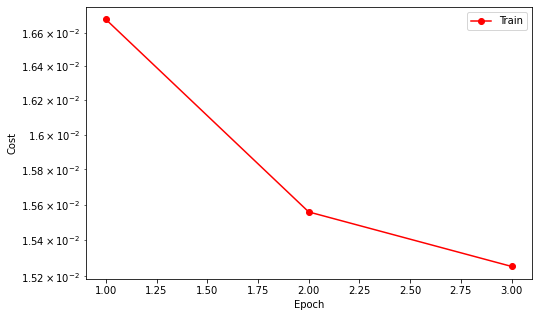

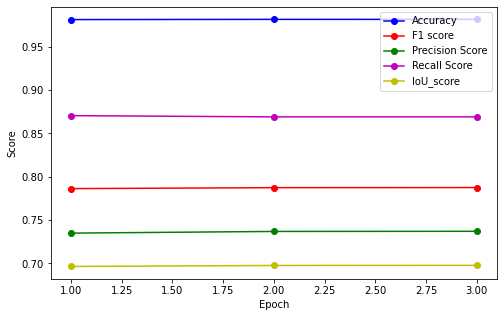

Train:   0%|          | 0/22915 [00:00<?, ?it/s]

Val:   0%|          | 0/2865 [00:00<?, ?it/s]


Epoch     4
Train_cost  = 0.0150 | Test_score = 0.9817 |F1_score = 0.7878 |Precision_score = 0.7387 |Recall_score = 0.8660 |IoU_score = 0.6982 |


Train:   0%|          | 0/22915 [00:00<?, ?it/s]

Val:   0%|          | 0/2865 [00:00<?, ?it/s]


Epoch     5
Train_cost  = 0.0149 | Test_score = 0.9814 |F1_score = 0.7872 |Precision_score = 0.7364 |Recall_score = 0.8697 |IoU_score = 0.6975 |
==> EarlyStop patience =  1 | Best F1_score: 0.7878


In [11]:
epoch = 5

for i in range(1,epoch+1):
    train_cost,_,_,_,_,_ = loop_fn('train',trainloader,model,criterion,optimizer,device)
    with torch.no_grad():
        _,test_score,F1_score,Precision_score,Recall_score,IoU_score = loop_fn('val',val_loader,model,criterion,optimizer,device)

    #logging
    #callback.log(test_score,None,train_cost,)
    callback.log(train_cost = train_cost, test_cost=None, train_score=None, test_score=test_score, F1_score=F1_score, Precision_score=Precision_score, Recall_score=Recall_score, IoU_score=IoU_score)
    #Checkpoint
    callback.save_checkpoint()
    #runtime plotting
    callback.cost_runtime_plotting()
    callback.score_runtime_plotting()
    #Early stopping
    if callback.early_stopping(model,monitor='F1_score'):
        callback.plot_cost()
        callback.plot_score()
        break

In [27]:
from tqdm.auto import tqdm
from PIL import Image
import torchvision.transforms as T
import time
convert_tensor = T.ToTensor()
with torch.no_grad():
    model.eval()
    cost = 0
    acc = 0
    lst_acc = []
    prec = 0
    rec = 0
    F1 = 0
    IoU = 0
    runtime = []
    for sample_batched in tqdm(val_loader, 'val'):
        data, target = sample_batched['data'].to(device), sample_batched['label'].type(torch.LongTensor).to(device) # LongTensor
        #optimizer.zero_grad()
        #start = time.time()
        output,_ = model(data)
        #end = time.time()
        #runtime.append((end-start))
        metric_calculator = SegmentationMetrics(average=True, ignore_background=False, activation='softmax')
        pixel_accuracy, F1_score, precision, recall,IoU_score = metric_calculator(target, output)
        lst_acc.append(pixel_accuracy.item())
        acc += pixel_accuracy.item()
        prec += precision.item()
        rec += recall.item()
        F1 += F1_score.item()
        IoU += IoU_score.item()
    
    start = time.time()
    output,_ = model(data)
    end = time.time()
    runtime.append((end-start))

        
#print(acc)
#print(prec)
#print(rec)
#print(IoU)
#print(F1)         
acc  /= 28
prec /= 28
rec  /= 28
F1   /= 28
IoU  /= 28
print(acc)
print(prec)
print(rec)
print(F1) 
print(runtime)
#print(IoU)

#len(val_loader.dataset)/batch_size
#len(lst_acc)

val:   0%|          | 0/28 [00:00<?, ?it/s]

0.985568607284308
0.6946415812258022
0.7914162743497112
0.7324999430899747
[0.0420076847076416]


In [22]:
runtime

[0.04100942611694336]

In [ ]:
def readTxt(file_path):
    img_list = []
    with open(file_path, 'r') as file_to_read:
        while True:
            lines = file_to_read.readline()
            #print(lines)
            if not lines:
                break
            item = lines.strip().split()
            img_list.append(item)
    file_to_read.close()
    return img_list

readTxt(val_path)